In [4]:
import pandas as pd
import numpy as np
import glob
import os
import datetime

startDate = '20200914'
endDate = '20200930'



readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

# rawOrderLog = pd.read_pickle(r'A:\temp\speedCheck\zt96_statwo_20200818.pkl')


for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1['diff'] = kk1['diff'].fillna(0)
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
k = pd.merge(k1, k2, on='accCode', how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks total order size < 30w')
try:
    assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog['tradeNtl'] = orderLog.groupby('order')['tradeNtl'].transform('sum')
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog['cumFillSize'] = orderLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
orderLog['status'] = np.where(orderLog['cumFillSize'] == 0, '3. no filled', 
                                np.where(orderLog['cumFillSize'] < orderLog['absOrderSize'], '2. partial filled', '1. full filled'))


startDate = '20200914'
endDate = '20200930'
readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'SZspeed_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    data = pd.read_pickle(path)
    checkData += [data]
checkLog = pd.concat(checkData).reset_index(drop=True)   
checkLog['date'].unique()

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
56323,20200914,8854,1603008,8905434,-1,30680
56326,20200914,528701,1603008,8905434,1,62141
70068,20200914,8854,1603298,2761528,-1,30710
70071,20200914,9551,1603298,2761528,1,41692
194557,20200914,5456,2002880,774305,1,19871
...,...,...,...,...,...,...
3591314,20200930,6623,2002677,1616000,-1,872855
3591318,20200930,6627,2002677,1616000,-1,873943
3591322,20200930,8854,2002677,1616000,1,876543
3591325,20200930,8865,2002677,1616000,-1,877120


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200914,5273,2300550,3100,7203,2
1,20200914,6683,2000688,1852523,27948,2
2,20200914,6683,2300723,1201900,29521,2
3,20200914,8854,2000688,2980019,30834,2
4,20200914,8854,2002961,556897,31125,2
...,...,...,...,...,...,...
526,20200930,9741,2002735,1029020,890098,2
527,20200930,9741,2002802,340600,890201,2
528,20200930,9741,2300492,151700,891001,2
529,20200930,9741,2300522,1074820,891087,2


99.64% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
7429,9735,300,400
8203,10691,6200,14600
9187,11799,90000,143700
10058,12769,2200,2300
15319,18984,3400,32200
...,...,...,...
646194,903421,500,800
646294,903542,19050,49000
646629,903970,19500,23300
648388,906732,500,700


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,...,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w


array([20200914, 20200915, 20200916, 20200917, 20200918, 20200921,
       20200922, 20200923, 20200924, 20200925, 20200928, 20200929,
       20200930], dtype=int64)

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import datetime


startDate = '20200803'
endDate = '20200911'
readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'SZspeed_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    data = pd.read_pickle(path)
    checkData += [data]
checkLog = pd.concat(checkData).reset_index(drop=True)   
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['accCode'].isnull()]
checkLog = checkLog.reset_index(drop=True)
checkLog['ordering'] = checkLog.index
checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog = checkLog.groupby(['date', 'colo'])['time_diff'].median().reset_index()

,date,colo,time_diff
0,20200803,zs_52_06,3708.5
1,20200803,zs_52_08,3888.5
2,20200803,zs_54_01,3538.5
3,20200803,zs_64_01,4924.5
4,20200803,zs_66_01,16792.0
...,...,...,...
510,20200911,zs_96_06,3792.5
511,20200911,zs_96_08,3739.0
512,20200911,zt_88_02,35674.0
513,20200911,zt_88_03,36838.0


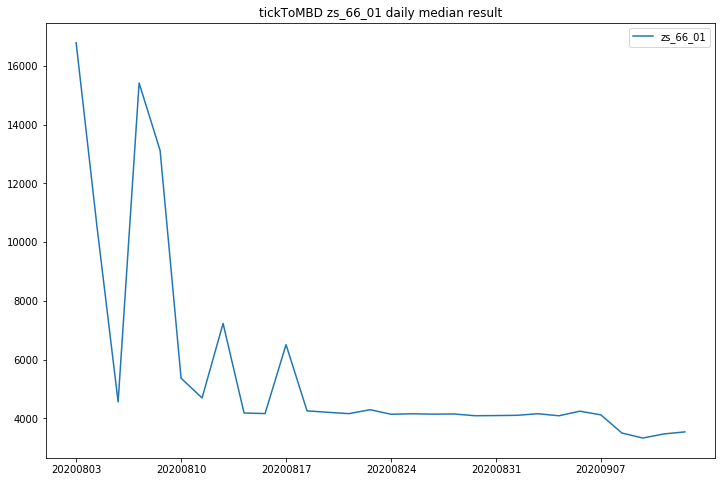

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
list1 = checkLog['colo'].unique()
list1 = list(list1)

list1.remove('zs_52_06')
list1.remove('zs_54_01')
list1.remove('zs_52_08')
list1.remove('zs_96_03')
list1.remove('zs_52_09')
list1.remove('zs_96_06')
list1.remove('zs_64_01')
list1.remove('zs_92_02')



list1.remove('zs_66_01')
list1.remove('zs_94_04')

list1.remove('zt_88_02')
list1.remove('zt_88_03')
list1.remove('zt_96_01')



for i in ['zs_66_01']:
    ax.plot(checkLog[checkLog['colo'] == i]['time_diff'].values, label=i)

ax.set_title('tickToMBD zs_66_01 daily median result')
indexLs = [i for i in range(checkLog[checkLog['colo'] == 'zs_52_06'].shape[0])]
dateLs = [int(i) for i in checkLog[checkLog['colo'] == 'zs_52_06']['date'].values]
ax.set_xticks(indexLs[::5])
ax.set_xticklabels(dateLs[::5])
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)


plt.show()

In [14]:
checkLog[checkLog['time_diff'] > 10000]['colo'].unique()

array(['zs_66_01', 'zs_94_04', 'zt_88_02', 'zt_88_03', 'zt_96_01'],
      dtype=object)

In [19]:
pd.set_option('max_rows', 200)
orderLog[(orderLog['colo'] == 'zs_96_08')].groupby(['date', 'accCode', 'sta'])['orderDirection'].unique()

date      accCode  sta   
20200817  6282     staone           [-1, 1]
                   statwo           [1, -1]
          9754     staone           [-2, 2]
                   statwo    [1, -1, -2, 2]
20200818  6282     staone           [1, -1]
                   statwo           [-1, 1]
          9754     staone           [-2, 2]
                   statwo    [-2, -1, 1, 2]
20200819  6282     statwo           [1, -1]
          9655     staone           [-1, 1]
                   statwo           [-1, 1]
          9685     staone           [-1, 1]
                   statwo           [-1, 1]
          9754     staone              [-2]
                   statwo    [-2, 1, -1, 2]
20200820  6282     staone           [-1, 1]
                   statwo           [-1, 1]
          9655     staone           [1, -1]
                   statwo           [-1, 1]
          9685     staone           [1, -1]
                   statwo           [-1, 1]
          9754     staone           [-2, 2]
      

In [81]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog['o_d'] = 0
checkLog['o_d'] = np.where(~checkLog['accCode'].isnull(), checkLog['Side'], checkLog['o_d'])
checkLog['o_d'] = checkLog.groupby('ApplSeqNum')['o_d'].transform('max')
d1 = checkLog[checkLog['o_d'] == checkLog['Side']]
d1['count'] = d1.groupby('ApplSeqNum')['date'].transform('size')
d1 = d1[d1['accCode'].isin([8865, 8967, 896702])]
d1['sta'] = np.where(d1['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
d1['colo_broker'] = d1['colo'].str[:2] + '_' + d1['accCode'].astype(str).str[:2]
display(d1[(d1['colo_broker'] == 'zs_88') & (d1['sta'] == 'statwo') & (d1['count'] == 1)].shape[0] / 
       d1[(d1['colo_broker'] == 'zs_88') & (d1['sta'] == 'statwo')].shape[0])
display(d1[(d1['colo_broker'] == 'zs_89') & (d1['sta'] == 'statwo') & (d1['count'] == 1)].shape[0] / 
       d1[(d1['colo_broker'] == 'zs_89') & (d1['sta'] == 'statwo')].shape[0])

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.15539246968730058

0.11518708730741012

In [207]:
checkLog['o_d'] = 0
checkLog['o_d'] = np.where(~checkLog['accCode'].isnull(), checkLog['Side'], checkLog['o_d'])
checkLog['o_d'] = checkLog.groupby('start_time')['o_d'].transform('max')
d1 = checkLog[(checkLog['o_d'] == checkLog['Side']) & (~checkLog['accCode'].isnull())]

d1['count'] = 0
d1['count'] = d1.groupby('start_time')['date'].transform('size')
d1['count'] = d1['count'] - 1

d1['front'] = 0
d1.loc[d1['accCode'].isin([8865, 8967, 896702]), 'front'] = 1
d1['front'] = d1.groupby('start_time')['front'].transform('cumsum')
d1['front'] = 1 - d1['front']


d1['agg'] = 0
d1['agg_price'] = 0
d1.loc[d1['accCode'].isin([8865, 8967, 896702]), 'agg_price'] = d1.loc[d1['accCode'].isin([8865, 8967, 896702]), 'Price']
d1['agg_price'] = d1.groupby('start_time')['agg_price'].transform('max')
d1['agg'] = np.where(((d1['Side'] == 1) & (d1['Price'] < d1['agg_price']) & (d1['front'] == 1)) | ((d1['Side'] == 2) & (d1['Price'] > d1['agg_price']) & (d1['front'] == 1)),
                     1, d1['agg'])
d1['agg'] = d1.groupby('start_time')['agg'].transform('sum')
d1['front'] = d1.groupby('start_time')['front'].transform('sum')

d1['sta'] = np.where(d1['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
d1['colo_broker'] = d1['colo'].str[:2] + '_' + d1['accCode'].astype(str).str[:2]
display(d1[(d1['colo_broker'] == 'zs_88') & (d1['sta'] == 'statwo') & (d1['count'] == 0)].shape[0] / 
       d1[(d1['colo_broker'] == 'zs_88') & (d1['sta'] == 'statwo')].shape[0])
display(d1[(d1['colo_broker'] == 'zs_89') & (d1['sta'] == 'statwo') & (d1['count'] == 0)].shape[0] / 
       d1[(d1['colo_broker'] == 'zs_89') & (d1['sta'] == 'statwo')].shape[0])

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

0.5678776290630975

0.5615835777126099

In [208]:
d1 = d1[d1['accCode'].isin([8865, 8967, 896702])]
d1['# of other orders in market'] = np.where(d1['count'] == 0, '0', np.where((d1['count'] >= 1) & (d1['count'] <= 2), '1-2',
                                                                            np.where((d1['count'] >= 3) & (d1['count'] <= 5), '3-5',
                                                                                    '>=6')))
re = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['date'].size().reset_index()
re = re.rename(columns={'date': 'size'})
re['count'] = re.groupby(['colo_broker', 'sta'])['size'].transform('sum')
re['%'] = re['size'] / re['count']
re['%'] = re['%'].apply(lambda x: '%.1f%%'%(100*x))
f = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['front'].sum().reset_index()
f1 = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['count'].sum().reset_index()
f2 = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['agg'].sum().reset_index()
f1 = f1.rename(columns={'count':"sum"})
re = pd.merge(re, f, on=['colo_broker', 'sta', '# of other orders in market'])
re = pd.merge(re, f1, on=['colo_broker', 'sta', '# of other orders in market'])
re = pd.merge(re, f2, on=['colo_broker', 'sta', '# of other orders in market'])
re['% orders in front'] = re['front'] / re['sum']
re['% orders in front'] = re['% orders in front'].fillna(0)
re['% orders in front'] = re['% orders in front'].apply(lambda x: '%.1f%%'%(100*x))
re['% orders more aggressive than front orders'] = re['agg'] / re['sum']
re['% orders more aggressive than front orders'] = re['% orders more aggressive than front orders'].fillna(0)
re['% orders more aggressive than front orders'] = re['% orders more aggressive than front orders'].apply(lambda x: '%.1f%%'%(100*x))
HTML(re.groupby(['colo_broker', 'sta', 'count','# of other orders in market'])['%', '% orders in front', '% orders more aggressive than front orders'].first().to_html())

In [212]:
checkLog['o_d'] = 0
checkLog['o_d'] = np.where(~checkLog['accCode'].isnull(), checkLog['Side'], checkLog['o_d'])
checkLog['o_d'] = checkLog.groupby('start_time')['o_d'].transform('max')
d1 = checkLog[checkLog['o_d'] == checkLog['Side']]

d1['count'] = 0
d1.loc[d1['accCode'].isnull(), 'count'] = d1[d1['accCode'].isnull()].groupby('start_time')['date'].transform('size')
d1['count'] = d1.groupby('start_time')['count'].transform('max')

d1 = d1[(d1['accCode'].isin([8865, 8967, 896702])) | (d1['accCode'].isnull())]
d1['front'] = 0
d1.loc[d1['accCode'].isin([8865, 8967, 896702]), 'front'] = 1
d1['front'] = d1.groupby('start_time')['front'].transform('cumsum')
d1['front'] = 1 - d1['front']

d1['agg'] = 0
d1['agg_price'] = 0
d1.loc[d1['accCode'].isin([8865, 8967, 896702]), 'agg_price'] = d1.loc[d1['accCode'].isin([8865, 8967, 896702]), 'Price']
d1['agg_price'] = d1.groupby('start_time')['agg_price'].transform('max')
d1['agg'] = np.where(((d1['Side'] == 1) & (d1['Price'] < d1['agg_price']) & (d1['front'] == 1)) | ((d1['Side'] == 2) & (d1['Price'] > d1['agg_price']) & (d1['front'] == 1)),
                     1, d1['agg'])
d1['agg'] = d1.groupby('start_time')['agg'].transform('sum')
d1['front'] = d1.groupby('start_time')['front'].transform('sum')


d1['sta'] = np.where(d1['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
d1['colo_broker'] = d1['colo'].str[:2] + '_' + d1['accCode'].astype(str).str[:2]
display(d1[(d1['colo_broker'] == 'zs_88') & (d1['sta'] == 'statwo') & (d1['count'] == 0)].shape[0] / 
       d1[(d1['colo_broker'] == 'zs_88') & (d1['sta'] == 'statwo')].shape[0])
display(d1[(d1['colo_broker'] == 'zs_89') & (d1['sta'] == 'statwo') & (d1['count'] == 0)].shape[0] / 
       d1[(d1['colo_broker'] == 'zs_89') & (d1['sta'] == 'statwo')].shape[0])

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.2731038878266412

0.18035190615835778

In [213]:
d1 = d1[~d1['accCode'].isnull()]
d1['# of other orders in market'] = np.where(d1['count'] == 0, '0', np.where((d1['count'] >= 1) & (d1['count'] <= 2), '1-2',
                                                                            np.where((d1['count'] >= 3) & (d1['count'] <= 5), '3-5',
                                                                                    '>=6')))
re = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['date'].size().reset_index()
re = re.rename(columns={'date': 'size'})
re['count'] = re.groupby(['colo_broker', 'sta'])['size'].transform('sum')
re['%'] = re['size'] / re['count']
re['%'] = re['%'].apply(lambda x: '%.1f%%'%(100*x))
f = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['front'].sum().reset_index()
f1 = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['count'].sum().reset_index()
f2 = d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['agg'].sum().reset_index()
f1 = f1.rename(columns={'count':"sum"})
re = pd.merge(re, f, on=['colo_broker', 'sta', '# of other orders in market'])
re = pd.merge(re, f1, on=['colo_broker', 'sta', '# of other orders in market'])
re = pd.merge(re, f2, on=['colo_broker', 'sta', '# of other orders in market'])
re['% orders in front'] = re['front'] / re['sum']
re['% orders in front'] = re['% orders in front'].fillna(0)
re['% orders in front'] = re['% orders in front'].apply(lambda x: '%.1f%%'%(100*x))
re['% orders more aggressive than front orders'] = re['agg'] / re['sum']
re['% orders more aggressive than front orders'] = re['% orders more aggressive than front orders'].fillna(0)
re['% orders more aggressive than front orders'] = re['% orders more aggressive than front orders'].apply(lambda x: '%.1f%%'%(100*x))
HTML(re.groupby(['colo_broker', 'sta', 'count','# of other orders in market'])['%', '% orders in front', '% orders more aggressive than front orders'].first().to_html())

In [221]:
checkLog['o_d'] = 0
checkLog['o_d'] = np.where(~checkLog['accCode'].isnull(), checkLog['Side'], checkLog['o_d'])
checkLog['o_d'] = checkLog.groupby('start_time')['o_d'].transform('max')
d1 = checkLog[checkLog['o_d'] == checkLog['Side']]
d1['M_competitor'] = 0
d1.loc[d1['accCode'].isnull(), 'M_competitor'] = 1
d1['I_competitor'] = 0
d1.loc[(~d1['accCode'].isnull()) & (~d1['accCode'].isin([8865, 8967, 896702])), 'I_competitor'] = 1
d1['M_competitor'] = d1.groupby('start_time')['M_competitor'].transform('sum')
d1['I_competitor'] = d1.groupby('start_time')['I_competitor'].transform('sum')
d1['competitors'] = d1.groupby('start_time')['ars'].transform('size')
d1['competitors'] = d1['competitors'] - 1
d1 = d1[d1['accCode'].isin([8865, 8967, 896702])]
d1['sta'] = np.where(d1['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
d1['colo_broker'] = d1['colo'].str[:2] + '_' + d1['accCode'].astype(str).str[:2]
re = d1.groupby(['colo_broker', 'sta'])['ars'].size().reset_index()
re = re.rename(columns={'ars':"count"})
f1 = d1.groupby(['colo_broker', 'sta'])['competitors'].sum()
re = pd.merge(re, f1, on=['colo_broker', 'sta'])
f2 = d1.groupby(['colo_broker', 'sta'])['M_competitor'].sum()
f3 = d1.groupby(['colo_broker', 'sta'])['I_competitor'].sum()
re = pd.merge(re, f2, on=['colo_broker', 'sta'])
re = pd.merge(re, f3, on=['colo_broker', 'sta'])
re

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

,colo_broker,sta,count,competitors,M_competitor,I_competitor
0,zs_88,staone,22,118,79,39
1,zs_88,statwo,3138,9834,7831,2003
2,zs_89,staone,933,4267,3540,727
3,zs_89,statwo,1364,5825,4860,965


In [165]:
d1.groupby(['colo_broker', 'sta', '# of other orders in market'])['front'].sum().reset_index()

colo_broker  sta     # of other orders in market
zs_88        staone  0                                0
                     1-2                              1
                     3-5                              6
                     >=6                             21
             statwo  0                                0
                     1-2                             87
                     3-5                            153
                     >=6                            347
zs_89        staone  0                                0
                     1-2                             33
                     3-5                             83
                     >=6                            471
             statwo  0                                0
                     1-2                             32
                     3-5                             68
                     >=6                            172
Name: front, dtype: int64

In [123]:
c1 = pd.merge(checkLog, d1[(d1['accCode'].isin([8967, 896702])) & (d1['statusLs'] == (0,3))][['ApplSeqNum', 'SecurityID', 'date']], how='right')
c1.head(50)

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,start_time,end_time,statusLs,TradePriceLs,TradeQtyLs,vai,ars,exchange,group,order,colo,accCode,o_d
0,28,13555177.0,1597719307892414,74998288,1.0,200.0,523200.0,4052628.0,1.0,105501980,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 4)","(0, 523200)","(0, 200)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,28,13555177.0,1597719307892678,74998291,1.0,4100.0,523200.0,4056528.0,1.0,105501980,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 4, 4, 4, 4, 4, 3)","(0, 523200, 523200, 523200, 523200, 523200, 0)","(0, 1600, 100, 200, 2000, 100, 0)",4052428.0,131.0,SZE,6743.0,16319.0,zs_96_08,9754.0,1.0
2,28,13555177.0,1597719307895097,74998313,1.0,2000.0,523200.0,4056528.0,0.0,105501980,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 3)","(0, 0)","(0, 0)",4052428.0,11.0,SZE,6743.0,21769.0,zs_88_04,896702.0,1.0
3,28,13555177.0,1597719307895147,74998314,1.0,200.0,523300.0,4056728.0,1.0,105501980,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 4, 4)","(0, 523300, 523300)","(0, 100, 100)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,28,13555177.0,1597719307909126,74998382,1.0,500.0,523100.0,4056828.0,0.0,105502000,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 3)","(0, 0)","(0, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,28,13555177.0,1597719307931146,74998506,1.0,400.0,523300.0,4057228.0,1.0,105502020,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 4, 4)","(0, 523300, 523300)","(0, 200, 200)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,28,13555177.0,1597719308018895,74999000,1.0,600.0,523300.0,4057828.0,1.0,105502110,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 4)","(0, 523300)","(0, 600)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,28,13555177.0,1597719308087945,74999725,1.0,7000.0,554200.0,4064928.0,1.0,105502180,0,0,0,2000028,2.813555e+09,20200818,1.597719e+15,1.597719e+15,"(0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4)","(0, 523300, 523300, 523300, 523300, 523300, 52...","(0, 2300, 1000, 400, 200, 500, 300, 200, 200, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,28,13555177.0,1597719308212560,75000470,1.0,100.0,523000.0,4064928.0,0.0,105502300,0,0,0,2000028,2.813556e+09,20200818,1.597719e+15,1.597719e+15,"(0, 3)","(0, 0)","(0, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,28,13555177.0,1597719308255727,75000660,1.0,100.0,523400.0,4065028.0,1.0,105502340,0,0,0,2000028,2.813556e+09,20200818,1.597719e+15,1.597719e+15,"(0, 4)","(0, 523400)","(0, 100)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [119]:
d1[(d1['accCode'] == 8865) & (d1['statusLs'] == (0,3))]

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,start_time,end_time,statusLs,TradePriceLs,TradeQtyLs,vai,ars,exchange,group,order,colo,accCode,o_d,count,sta,colo_broker
5900,403,14949247.0,1597640690246954,95627323,2.0,1900.0,403300.0,1938590.0,0.0,130444530,0,0,0,2000403,4.031495e+10,20200817,1.597641e+15,1.597641e+15,"(0, 3)","(0, 0)","(0, 0)",1935990.0,131.0,SZE,10432.0,14587.0,zs_88_04,8865.0,2.0,3,statwo,zs_88
10329,601,12302897.0,1597633397213535,77916659,1.0,26400.0,74400.0,8921398.0,0.0,110311520,0,0,0,2000601,6.011230e+10,20200817,1.597633e+15,1.597633e+15,"(0, 3)","(0, 0)","(0, 0)",8893498.0,131.0,SZE,11081.0,14605.0,zs_88_04,8865.0,1.0,8,statwo,zs_88
13345,688,19345800.0,1597643436388891,120480700,2.0,100.0,227600.0,1745755.0,0.0,135030670,0,0,0,2000688,6.881935e+10,20200817,1.597643e+15,1.597643e+15,"(0, 3)","(0, 0)","(0, 0)",1745655.0,131.0,SZE,11500.0,14610.0,zs_88_04,8865.0,2.0,2,statwo,zs_88
25428,831,12302664.0,1597633397152378,77914936,1.0,21100.0,157900.0,15700903.0,0.0,110311460,0,0,0,2000831,8.311230e+10,20200817,1.597633e+15,1.597633e+15,"(0, 3)","(0, 0)","(0, 0)",15676803.0,131.0,SZE,12034.0,14626.0,zs_88_04,8865.0,1.0,6,statwo,zs_88
33775,2022,19960595.0,1597644430906638,128470657,2.0,19700.0,211800.0,8340255.0,0.0,140705180,0,0,0,2002022,2.022200e+11,20200817,1.597644e+15,1.597644e+15,"(0, 3)","(0, 0)","(0, 0)",8317685.0,131.0,SZE,13027.0,14653.0,zs_88_04,8865.0,2.0,10,statwo,zs_88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076554,2930,19138124.0,1598594434264329,110319715,1.0,1200.0,217500.0,6968646.0,0.0,140026250,0,0,0,2002930,2.930191e+11,20200828,1.598594e+15,1.598594e+15,"(0, 3)","(0, 0)","(0, 0)",6964446.0,131.0,SZE,21315.0,16279.0,zs_88_04,8865.0,1.0,9,statwo,zs_88
1076725,2930,19934491.0,1598594877206177,114973466,2.0,500.0,219800.0,7883214.0,0.0,140749190,0,0,0,2002930,2.930199e+11,20200828,1.598595e+15,1.598595e+15,"(0, 3)","(0, 0)","(0, 0)",7882114.0,131.0,SZE,21332.0,16288.0,zs_88_04,8865.0,2.0,13,statwo,zs_88
1077945,2947,24505393.0,1598597532169125,142296847,2.0,300.0,588100.0,1410432.0,0.0,145204140,0,0,0,2002947,2.947245e+11,20200828,1.598598e+15,1.598598e+15,"(0, 3)","(0, 0)","(0, 0)",1410132.0,131.0,SZE,21543.0,16291.0,zs_88_04,8865.0,2.0,7,statwo,zs_88
1077951,2947,24518619.0,1598597538384562,142375228,2.0,500.0,587700.0,1412832.0,0.0,145210360,0,0,0,2002947,2.947245e+11,20200828,1.598598e+15,1.598598e+15,"(0, 3)","(0, 0)","(0, 0)",1412332.0,131.0,SZE,21544.0,16292.0,zs_88_04,8865.0,2.0,3,statwo,zs_88


In [5]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['accCode'].isnull()]
checkLog = pd.merge(checkLog, orderLog[(orderLog['updateType'] == 0) & (orderLog['exchange'] == 'SZE')
                                & (orderLog['ApplSeqNum'] != 0)][['orderDirection', 'date', 'colo', 'accCode', 'secid', 'ApplSeqNum', 'status', 'orderNtl', 'tradeNtl', 'colo_broker']],
             on=['date', 'colo', 'accCode', 'secid', 'ApplSeqNum'])
checkLog['sta'] = np.where(checkLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog['c'] = checkLog['accCode'].astype(str).str[:2].astype(int)
checkLog['type'] = np.where(checkLog['c'] %2 == 0, '正常', np.where(
checkLog['orderDirection'].isin([-2, 2]), '融资融券异常', '融资融券正常'))

In [54]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['accCode'].isnull()]
checkLog[checkLog['colo_broker'].isin(['zs_96', 'zs_97'])].groupby(['colo_broker', 'sta', 'status'])['vai'].size()

colo_broker  sta     status           
zs_96        staone  1. full filled        2012
                     2. partial filled       40
                     3. no filled            34
             statwo  1. full filled        4298
                     2. partial filled       92
                     3. no filled            56
zs_97        staone  1. full filled       10893
                     2. partial filled      957
                     3. no filled          2988
             statwo  1. full filled        8318
                     2. partial filled      665
                     3. no filled           690
Name: vai, dtype: int64

In [56]:
d1['time_diff'] = d1['clockAtArrival'] - d1['start_time']
HTML(d1.groupby(['colo_broker', 'sta', 'status'])['time_diff'].describe()[['count', '25%', '50%', '75%']].to_html())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
d1 = checkLog[checkLog['colo_broker'].isin(['zs_96', 'zs_97'])]
da1 = d1.groupby(['colo_broker', 'sta', 'status'])['orderNtl'].sum().reset_index()
da2 = d1.groupby(['colo_broker', 'sta', 'status'])['tradeNtl'].sum().reset_index()
da3 = d1.groupby(['colo_broker', 'sta', 'status'])['vai'].size().reset_index()
da3 = da3.rename(columns={'vai':"size"})
da3['size_sum'] = da3.groupby(['colo_broker', 'sta'])['size'].transform('sum')
da3['size_perc'] = da3['size'] / da3['size_sum']
da3['size_perc'] = da3['size_perc'].apply(lambda x: '%.1f%%'%(100*x))
da2 = pd.concat([da2, pd.DataFrame({'colo_broker':['zs_88'], 'sta':['staone'], 'status':['3. no filled'], 'tradeNtl':[0]}),
                pd.DataFrame({'colo_broker':['zs_88'], 'sta':['statwo'], 'status':['3. no filled'], 'tradeNtl':[0]}),
                pd.DataFrame({'colo_broker':['zs_89'], 'sta':['staone'], 'status':['3. no filled'], 'tradeNtl':[0]}),
                pd.DataFrame({'colo_broker':['zs_89'], 'sta':['statwo'], 'status':['3. no filled'], 'tradeNtl':[0]})], axis=0)
da = pd.merge(da1, da2, on=['colo_broker', 'sta', 'status'])
da = pd.merge(da, da3, on=['colo_broker', 'sta', 'status'])
da['perc'] = da['tradeNtl'] / da['orderNtl']
da['perc'] = da['perc'].apply(lambda x: '%.1f%%'%(100*x))
HTML(da.groupby(['colo_broker', 'sta', 'size_sum', 'status']).first().to_html())

In [4]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['accCode'].isnull()]
checkLog = checkLog.reset_index(drop=True)
checkLog['ordering'] = checkLog.index
checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog['colo1'] = checkLog['colo'].str[:2]
checkLog['colo_broker'] = checkLog['colo1'] + '_' + checkLog["accCode"].astype(str).str[:2]
checkLog = checkLog[checkLog['colo_broker'].isin(['zs_88', 'zs_89'])]
checkLog['accCode'] = checkLog['accCode'].astype(int)
checkLog['sta'] = np.where(checkLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog1 = checkLog[checkLog['sta'] == 'statwo']
ol = pd.merge(checkLog[checkLog['sta'] == 'staone'], checkLog[checkLog['sta'] == 'statwo'][['colo', 'accCode']].drop_duplicates(),
         on=['colo', 'accCode'], how='inner')['ordering'].unique()
checkLog2 = checkLog[(checkLog['sta'] == 'staone') & (~checkLog['ordering'].isin(ol))]

from IPython.display import display, HTML
re1 = checkLog1.groupby(['sta', 'colo', 'accCode'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog1.groupby(['sta', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'accCode', '10%']], on=['sta', 'colo', 'accCode'])
c1 = checkLog1.groupby(['sta', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'accCode', '90%']], on=['sta', 'colo', 'accCode'])

display(HTML(re1[['sta', 'colo', 'accCode', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo', 'accCode']).first().to_html()))

from IPython.display import display, HTML
re1 = checkLog2.groupby(['sta', 'colo', 'accCode'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog2.groupby(['sta', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'accCode', '10%']], on=['sta', 'colo', 'accCode'])
c1 = checkLog2.groupby(['sta', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'accCode', '90%']], on=['sta', 'colo', 'accCode'])

display(HTML(re1[['sta', 'colo', 'accCode', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo', 'accCode']).first().to_html()))

# checkLog3 = pd.concat([checkLog[checkLog['sta'] == 'statwo'], checkLog[(checkLog['sta'] == 'staone') & 
#                                     (checkLog['ordering'].isin(ol))], 
#                       checkLog[(checkLog['sta'] == 'staone') & 
#                                     (~checkLog['ordering'].isin(ol)) & (checkLog['TransactTime'] <= 93300000)]])
# from IPython.display import display, HTML
# re1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# # re1 = re1[re1['count'] > 20].reset_index()
# c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
# c1 = c1.rename(columns={"time_diff":"10%"})
# re1 = pd.merge(re1, c1[['sta', 'colo', '10%']], on=['sta', 'colo'])
# c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
# c1 = c1.rename(columns={"time_diff":"90%"})
# re1 = pd.merge(re1, c1[['sta', 'colo', '90%']], on=['sta', 'colo'])

# display(HTML(re1[['sta', 'colo', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['sta', 'colo']).first().to_html()))

checkLog3 = checkLog[(checkLog['sta'] == 'staone') &  (checkLog['ordering'].isin(ol))]
from IPython.display import display, HTML
re1 = checkLog3.groupby(['sta', 'colo', 'accCode'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog3.groupby(['sta', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'accCode', '10%']], on=['sta', 'colo', 'accCode'])
c1 = checkLog3.groupby(['sta', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'accCode', '90%']], on=['sta', 'colo', 'accCode'])

display(HTML(re1[['sta', 'colo', 'accCode', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo', 'accCode']).first().to_html()))

AttributeError: 'Index' object has no attribute 'remove_unused_levels'

In [6]:
cc1 = checkLog[checkLog['type'] == '正常']
cc1 = cc1.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
cc1 = cc1.reset_index(drop=True)
cc1['ordering'] = cc1.index
cc1['time_diff'] = cc1['clockAtArrival'] - cc1['start_time']
cc1['colo1'] = cc1['colo'].str[:2]
cc1['colo_broker'] = cc1['colo1'] + '_' + cc1["accCode"].astype(str).str[:2]
cc1['accCode'] = cc1['accCode'].fillna(0).astype(int)
cc1['sta'] = np.where(cc1['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog1 = cc1[cc1['sta'] == 'statwo']
ol = pd.merge(cc1[cc1['sta'] == 'staone'], cc1[cc1['sta'] == 'statwo'][['colo', 'accCode']].drop_duplicates(),
         on=['colo', 'accCode'], how='inner')['ordering'].unique()
checkLog2 = cc1[(cc1['sta'] == 'staone') & (~cc1['ordering'].isin(ol))]

from IPython.display import display, HTML
re1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

from IPython.display import display, HTML
re1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

# checkLog3 = pd.concat([checkLog[checkLog['sta'] == 'statwo'], checkLog[(checkLog['sta'] == 'staone') & 
#                                     (checkLog['ordering'].isin(ol))], 
#                       checkLog[(checkLog['sta'] == 'staone') & 
#                                     (~checkLog['ordering'].isin(ol)) & (checkLog['TransactTime'] <= 93300000)]])
# from IPython.display import display, HTML
# re1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# # re1 = re1[re1['count'] > 20].reset_index()
# c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
# c1 = c1.rename(columns={"time_diff":"10%"})
# re1 = pd.merge(re1, c1[['sta', 'colo', '10%']], on=['sta', 'colo'])
# c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
# c1 = c1.rename(columns={"time_diff":"90%"})
# re1 = pd.merge(re1, c1[['sta', 'colo', '90%']], on=['sta', 'colo'])

# display(HTML(re1[['sta', 'colo', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['sta', 'colo']).first().to_html()))

checkLog3 = cc1[(cc1['sta'] == 'staone') &  (cc1['ordering'].isin(ol))]
from IPython.display import display, HTML
re1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

In [7]:
cc1 = checkLog[checkLog['type'] == '融资融券异常']
cc1 = cc1.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
cc1 = cc1.reset_index(drop=True)
cc1['ordering'] = cc1.index
cc1['time_diff'] = cc1['clockAtArrival'] - cc1['start_time']
cc1['colo1'] = cc1['colo'].str[:2]
cc1['colo_broker'] = cc1['colo1'] + '_' + cc1["accCode"].astype(str).str[:2]
cc1['accCode'] = cc1['accCode'].fillna(0).astype(int)
cc1['sta'] = np.where(cc1['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog1 = cc1[cc1['sta'] == 'statwo']
ol = pd.merge(cc1[cc1['sta'] == 'staone'], cc1[cc1['sta'] == 'statwo'][['colo', 'accCode']].drop_duplicates(),
         on=['colo', 'accCode'], how='inner')['ordering'].unique()
checkLog2 = cc1[(cc1['sta'] == 'staone') & (~cc1['ordering'].isin(ol))]

from IPython.display import display, HTML
re1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

from IPython.display import display, HTML
re1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

checkLog3 = cc1[(cc1['sta'] == 'staone') &  (cc1['ordering'].isin(ol))]
from IPython.display import display, HTML
re1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

AttributeError: 'Index' object has no attribute 'remove_unused_levels'

In [8]:
cc1 = checkLog[checkLog['type'] == '融资融券正常']
cc1 = cc1.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
cc1 = cc1.reset_index(drop=True)
cc1['ordering'] = cc1.index
cc1['time_diff'] = cc1['clockAtArrival'] - cc1['start_time']
cc1['colo1'] = cc1['colo'].str[:2]
cc1['colo_broker'] = cc1['colo1'] + '_' + cc1["accCode"].astype(str).str[:2]
cc1['accCode'] = cc1['accCode'].fillna(0).astype(int)
cc1['sta'] = np.where(cc1['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog1 = cc1[cc1['sta'] == 'statwo']
ol = pd.merge(cc1[cc1['sta'] == 'staone'], cc1[cc1['sta'] == 'statwo'][['colo', 'accCode']].drop_duplicates(),
         on=['colo', 'accCode'], how='inner')['ordering'].unique()
checkLog2 = cc1[(cc1['sta'] == 'staone') & (~cc1['ordering'].isin(ol))]

from IPython.display import display, HTML
re1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog1.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

from IPython.display import display, HTML
re1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog2.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

# checkLog3 = pd.concat([checkLog[checkLog['sta'] == 'statwo'], checkLog[(checkLog['sta'] == 'staone') & 
#                                     (checkLog['ordering'].isin(ol))], 
#                       checkLog[(checkLog['sta'] == 'staone') & 
#                                     (~checkLog['ordering'].isin(ol)) & (checkLog['TransactTime'] <= 93300000)]])
# from IPython.display import display, HTML
# re1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# # re1 = re1[re1['count'] > 20].reset_index()
# c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
# c1 = c1.rename(columns={"time_diff":"10%"})
# re1 = pd.merge(re1, c1[['sta', 'colo', '10%']], on=['sta', 'colo'])
# c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
# c1 = c1.rename(columns={"time_diff":"90%"})
# re1 = pd.merge(re1, c1[['sta', 'colo', '90%']], on=['sta', 'colo'])

# display(HTML(re1[['sta', 'colo', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['sta', 'colo']).first().to_html()))

checkLog3 = cc1[(cc1['sta'] == 'staone') &  (cc1['ordering'].isin(ol))]
from IPython.display import display, HTML
re1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '10%']], on=['sta', 'colo_broker', 'colo'])
c1 = checkLog3.groupby(['sta', 'colo_broker', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo_broker', 'colo', '90%']], on=['sta', 'colo_broker', 'colo'])

display(HTML(re1[['sta', 'colo_broker', 'colo', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo_broker', 'colo']).first().to_html()))

AttributeError: 'Index' object has no attribute 'remove_unused_levels'

In [2]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog.reset_index(drop=True)
checkLog['ordering'] = checkLog.index
checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog['colo1'] = checkLog['colo'].str[:2]
checkLog['colo_broker'] = checkLog['colo1'] + '_' + checkLog["accCode"].astype(str).str[:2]
checkLog['sta'] = np.where(checkLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog1 = checkLog[(checkLog['sta'] == 'statwo')]
ol = pd.merge(checkLog[checkLog['sta'] == 'staone'], checkLog[checkLog['sta'] == 'statwo'][['colo', 'accCode']].drop_duplicates(),
         on=['colo', 'accCode'], how='inner')['ordering'].unique()
checkLog2 = checkLog[(checkLog['sta'] == 'staone') & (~checkLog['ordering'].isin(ol))]

from IPython.display import display, HTML
re1 = checkLog1.groupby(['sta', 'colo', 'colo_broker'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog1.groupby(['sta', 'colo', 'colo_broker'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'colo_broker', '10%']], on=['sta', 'colo', 'colo_broker'])
c1 = checkLog1.groupby(['sta', 'colo', 'colo_broker'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'colo_broker', '90%']], on=['sta', 'colo', 'colo_broker'])

display(HTML(re1[['sta', 'colo', 'colo_broker', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo', 'colo_broker']).first().to_html()))

from IPython.display import display, HTML
re1 = checkLog2.groupby(['sta', 'colo', 'colo_broker'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog2.groupby(['sta', 'colo', 'colo_broker'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'colo_broker', '10%']], on=['sta', 'colo', 'colo_broker'])
c1 = checkLog2.groupby(['sta', 'colo', 'colo_broker'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo', 'colo_broker', '90%']], on=['sta', 'colo', 'colo_broker'])

display(HTML(re1[['sta', 'colo', 'colo_broker', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'colo', 'colo_broker']).first().to_html()))

checkLog3 = pd.concat([checkLog[checkLog['sta'] == 'statwo'], checkLog[(checkLog['sta'] == 'staone') & 
                                    (checkLog['ordering'].isin(ol))], 
                      checkLog[(checkLog['sta'] == 'staone') & 
                                    (~checkLog['ordering'].isin(ol)) & (checkLog['TransactTime'] <= 93300000)]])
from IPython.display import display, HTML
re1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['sta', 'colo', '10%']], on=['sta', 'colo'])
c1 = checkLog3.groupby(['sta', 'colo'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['sta', 'colo', '90%']], on=['sta', 'colo'])

display(HTML(re1[['sta', 'colo', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['sta', 'colo']).first().to_html()))
